# Importing required python modules:

In [239]:
import pandas as pd
import numpy as np
from numpy import log
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import folium.plugins # The Folium Javascript Map Library
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split, ParameterGrid, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, mean_squared_error,r2_score, explained_variance_score
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
%matplotlib inline

In [252]:
#Import the datafile
df0=pd.read_csv('data_with_WSigLmrkSol.csv', parse_dates=['Date'], index_col='Date')
#Delete the unnecessary column appeared in the input file
df0.drop(columns='Unnamed: 0', axis=1, inplace=True)
#About 10 to 20 entries in are missing for the weather related data, we handled those by using the value of its immediate past.
df0.windSpeed.fillna(method='ffill', inplace=True)
df0.temperature.fillna(method='ffill', inplace=True)
df0.humidity.fillna(method='ffill', inplace=True)
#List of column-indices of the imported data file
df0.columns

Index(['Time', 'year', 'month', 'day', 'hour', 'DayOfWeek', 'DayOfYear',
       'Holiday', 'Latitude', 'Longitude', 'Location', 'Weather', 'pcpt_mmph',
       'visibility', 'humidity', 'windSpeed', 'Signals', 'Schools',
       'Landmarks', 'Solar_inclination', 'temperature', 'dewPoint',
       'Issue Reported', 'Accident'],
      dtype='object')

In [253]:
#Convert the categorical data values into string type
def convert_to_string(data):
    string_data = data.apply(str)
    return string_data

In [254]:
def rmse_mae(actual, predicted):
    r_square = r2_score(actual, predicted)
    rmse =  np.sqrt(mean_squared_error(actual, predicted))
    mape=np.mean(abs(actual-predicted)/np.mean(abs(actual)))
    print('R_Square: %.2f' %r_square, '\nRoot mean squared error (RMSE): %.3f' % rmse, '\nThe mean absolute percentage error (MAPE): %.2f' % (100*mape),'''%''')

# 1. Time Series Forecasting Models:

In [7]:
#Calculate the total daily accidents
df=pd.DataFrame(df0.groupby('Date').sum()['Accident'])

## A. Baseline Model:

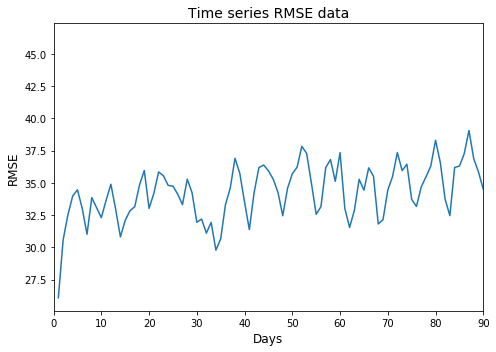

In [312]:
#Persistence Forecast Algorithm

#The daily accident data
X = df.Accident.values
#first 'length' data are set to be training data set
length = 600
#length of the test data 
p_length = int(len(X)-length)
#split the train test sets of time series data
train, test = X[0:-length], X[-p_length:]
#The number of data points to be used for forecast
persistence_values = range(1,p_length)
###
scores = list()
for p in persistence_values:
    # walk-forward validation
    history = [x for x in train]
    predictions=[]
    for i in range(len(test)):
        #make prediction
        yhat=history[-p]
        predictions.append(yhat)
        #observation
        history.append(test[i])
    rmse = np.sqrt(mean_squared_error(test, predictions))
    scores.append(rmse)
    #print('p=%d RMSE:%.3f' % (p, rmse))
# plot scores over persistence values
fig, ax=plt.subplots(figsize=(7, 5))
plt.plot(persistence_values, scores)
plt.xlabel('Days', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.xlim(0,90)
plt.title('Time series RMSE data',fontsize=14)
plt.tight_layout()
plt.savefig('baseline_persistence_model.pdf')

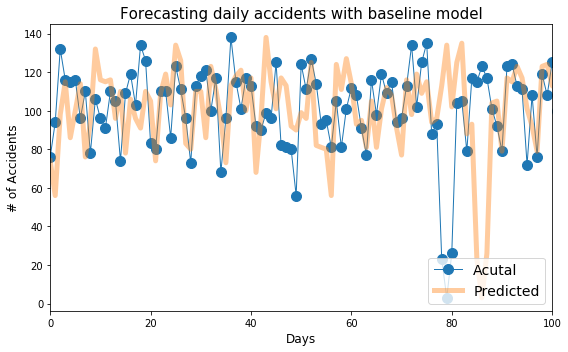

In [24]:
#Now, make predictions as the forecast for the future test set of data. 
#The pattern of the rmse shows the minima of errors are every 7th day. 
#Therefore, the forecast is based on the data occurred on 7 day ago. 
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # make prediction
    yhat = history[-7]
    predictions.append(yhat)
    # observation
    history.append(test[i])
# plot predictions vs observations
fig, ax=plt.subplots(figsize=(8,5))
plt.plot(test,linewidth=1, label='Acutal', marker='o', markersize=10.0, )
plt.plot(predictions, linewidth=5.0, alpha=0.4, label='Predicted')
plt.legend(loc=4, fontsize=14)
plt.xlim(0,100)
plt.xlabel('Days', fontsize=12)
plt.ylabel('# of Accidents', fontsize=12)
plt.title('Forecasting daily accidents with baseline model', fontsize=15)
plt.tight_layout()
plt.savefig('baseline_persistnece_forecasting.pdf')

In [28]:
#Calculate the errors, rmse and mean absolute percentage error. 
rmse_mae(test, predictions)

R_Square: -0.88 
Root mean squared error (RMSE): 31.019 
The mean absolute percentage error (MAPE): 21.12 %


Window with minimum RMSE:  99 
Minimum RMSE:  22.60259331715401


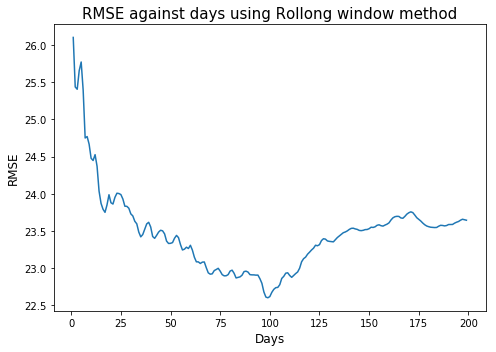

In [311]:
#Rolling Window model:
rmss=100
window_sizes = range(1, 200)
scores = list()
for w in window_sizes:
    # walk-forward validation
    history = [x for x in train]
    predictions = list()
    for i in range(len(test)):
        # make prediction
        yhat = np.mean(history[-w:])
        predictions.append(yhat)
        # observation
        history.append(test[i])
    # report performance
    rmse =  np.sqrt(mean_squared_error(test, predictions))
    scores.append(rmse)
    if rmse < rmss:
        rmss=rmse
        ww = w
    #print('w=%d RMSE:%.3f' % (w, rmse))
print('Window with minimum RMSE: ', ww, '\nMinimum RMSE: ', rmss)
# plot scores over window sizes values
fig, ax=plt.subplots(figsize=(7, 5))
plt.plot(window_sizes, scores)
plt.xlabel('Days', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.title('RMSE against days using Rollong window method', fontsize=15)
plt.tight_layout()
plt.savefig('Rolling_window_baseline.pdf')

Text(0.5, 1.0, 'Forecasting daily accidents with Rolling window method')

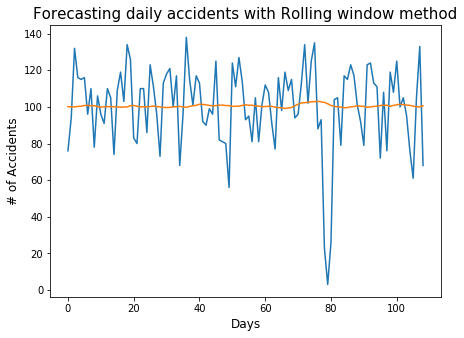

In [310]:
#Prediction made using the window with minimum rmse: 
predictions = list()
for i in range(len(test)):
    # make prediction
    yhat = np.mean(history[-99:])
    predictions.append(yhat)
    # observation
    history.append(test[i])
# plot predictions vs observations
fig, ax=plt.subplots(figsize=(7,5))
plt.plot(test)
plt.plot(predictions)
plt.xlabel('Days', fontsize=12)
plt.ylabel('# of Accidents',fontsize=12)
plt.title('Forecasting daily accidents with Rolling window method',fontsize=15)

In [40]:
rmse_mae(test, predictions)

R_Square: -0.02 
Root mean squared error (RMSE): 22.791 
The mean absolute percentage error (MAPE): 17.05 %


Although, the errors RMSE and MAPE are better than the persistence forecast algorithm, from the plot we can see this model only forecast the trend. The up and down values are not predicted good. We can not suggest this model for forecasting the data for specific time and dates. 

## B. ARIMA model: 

In [41]:
#To check the stationarity of the time series we check the daily accident data by using ad-fuller test. 
#The adfuller is already imported from the python statsmodel library. We use the adfuller here. 
result = adfuller(df.Accident)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -5.180979
p-value: 0.000010


Since the p-value is < 0.05, the data is sationary and no further differentiation is required. 

/usr/local/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


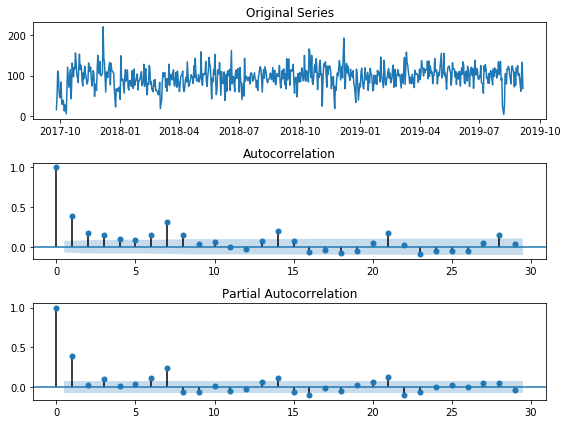

In [42]:
#To figure out the parameters p (AR) and q (MA) of our time series forecasting model, we calculate the correlogram:
#Plot the acf and pacf
fig, axes = plt.subplots(3, 1, figsize=(8, 6))
axes[0].plot(df.Accident)
axes[0].set_title('Original Series')
plot_acf(df.Accident, ax=axes[1])
plot_pacf(df.Accident, ax=axes[2])
plt.tight_layout()

From the acf plot we can see the there are first 3 lags out of significance level. 
So, we choose q = 3. From the pacf, the data points are out of significance level upto lag = 2, so, we choose p = 2. We choose the value of d = 0, since the time series data is stationary as seen from adfuller test above. 

In [43]:
#We split the dataset into train and test sets as a fraction of the original data 
test_size=0.2
train_len=int((1-test_size)*len(df.Accident))
test_len=len(df.Accident)-train_len
#print the train and lest size here:
print('Size of train set: ', train_len, '\nSize of test set: ', test_len)
y_train = df.Accident[:train_len]
y_test=df.Accident[train_len:]

Size of train set:  567 
Size of test set:  142


### a. ARIMA with only time series data set (Target):

In [76]:
# 2, 0, 3 ARIMA Model with target variable y_train 
model = ARIMA(y_train, order=(2,0,3))
model_fit = model.fit(disp=0)
print(model_fit.summary())

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                              ARMA Model Results                              
Dep. Variable:               Accident   No. Observations:                  567
Model:                     ARMA(2, 3)   Log Likelihood               -2613.846
Method:                       css-mle   S.D. of innovations             24.307
Date:                Sun, 08 Dec 2019   AIC                           5241.691
Time:                        10:56:12   BIC                           5272.074
Sample:                    09-26-2017   HQIC                          5253.549
                         - 04-15-2019                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             94.9162      1.632     58.170      0.000      91.718      98.114
ar.L1.Accident     0.3782      0.224      1.685      0.093      -0.062       0.818
ar.L2.Accident    -0.4910      0.125

In [77]:
#For forecasting the data corresponding to the test set (y_test) we use the rolling window model. 
#Rolling window ARIMA
predictions=[]
history=[x for x in y_train]
for t in range(len(y_test)):
    model = ARIMA(history, order=(2,0,3))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat=output[0][0]
    obs=y_test[t]
    predictions.append(yhat)
    history.append(obs)

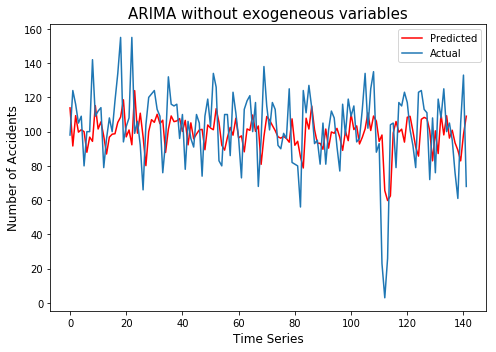

In [309]:
#y_test data are for the last 142 days. 
ytest=y_test.reset_index().drop('Date',axis=1)
# plot
fig, ax=plt.subplots(figsize=(7,5))
plt.plot(predictions, color='red', label='Predicted')
plt.plot(ytest, label='Actual')
plt.legend()
plt.xlabel('Time Series', fontsize=12)
plt.ylabel('Number of Accidents', fontsize=12)
plt.title('ARIMA without exogeneous variables', fontsize=15)
plt.tight_layout()
plt.savefig('arima_without_ex-variables.pdf')

In [79]:
rmse_mae(y_test, predictions)

R_Square: 0.03 
Root mean squared error (RMSE): 21.830 
The mean absolute percentage error (MAPE): 16.92 %


Mean: 0.0458 
Standard deviation: 23.7808


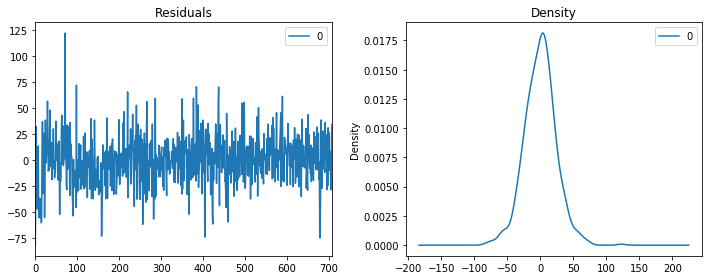

In [80]:
residuals=pd.DataFrame(model_fit.resid)
print('Mean: %.4f' %np.mean(residuals), '\nStandard deviation: %.4f' %np.std(residuals))
fig, ax = plt.subplots(1,2, figsize=(10,4))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.tight_layout()

Residulas are distributed with mean close to zero (0.0458) and with standard deviation 23.78.





.

.



The RMSE and MAPE both are better than that obtained from the baseline models. We assume to get better performance if we include the other features as exogeneous variables.  

### b. ARIMA with exogeneous variables:

In [284]:
#Features (exogeneous variables) mean daily values
X=df0.groupby(['Date']).mean()[['Longitude','Latitude','windSpeed','visibility','pcpt_mmph','temperature','dewPoint', 'humidity','DayOfWeek','day','month']]
#Target (endogeneous variable)
y=df

In [291]:
X_train = X[:train_len]
X_test=X[train_len:]
y_train=y[:train_len]
y_test=y[train_len:]

In [292]:
#X_train are included as exogeneous varaibles:
model = ARIMA(endog=y_train, exog=X_train, order=(2,0, 3))  
fitted = model.fit() 

# Forecast
fc, se, conf = fitted.forecast(test_len, exog=X_test, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=y_test.index)
lower_series = pd.Series(conf[:, 0], index=y_test.index)
upper_series = pd.Series(conf[:, 1], index=y_test.index)

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


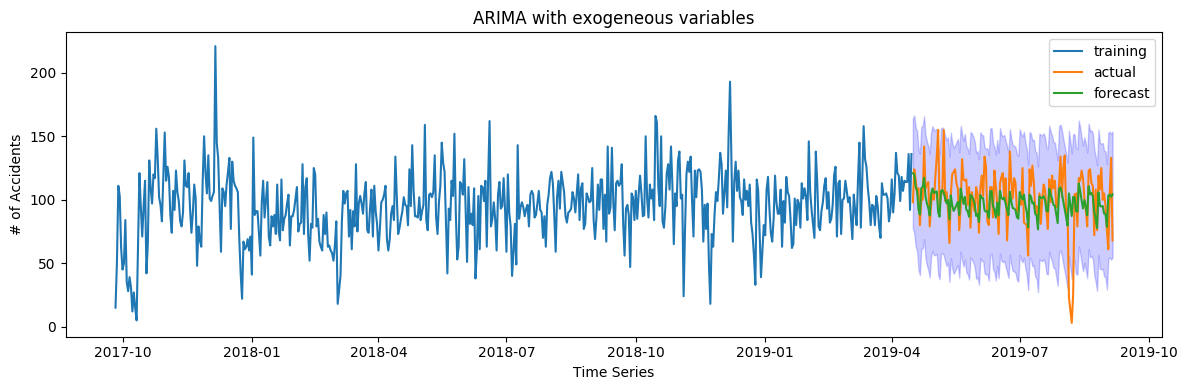

In [307]:
# Plot
plt.figure(figsize=(12,4), dpi=100)
plt.plot(y_train, label='training')
plt.plot(y_test, label='actual')
plt.plot(fc_series,label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='b', alpha=.2)
plt.xlabel('Time Series')
plt.ylabel('# of Accidents')
plt.title('ARIMA with exogeneous variables')
plt.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.savefig('Arima_prediction.pdf')

In [294]:
rmse_mae(y_test.Accident, fc)

R_Square: 0.06 
Root mean squared error (RMSE): 21.403 
The mean absolute percentage error (MAPE): 15.14 %


As expected we get the better performance when we include the exogeneous variables. 

Mean: 0.3235 
Standard deviation: 22.1875


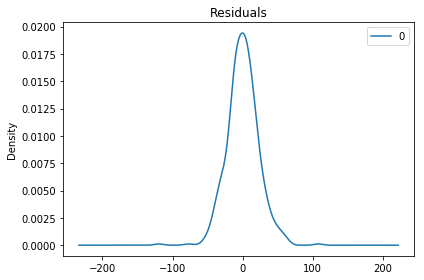

In [305]:
residuals=pd.DataFrame(fitted.resid)
print('Mean: %.4f' %np.mean(residuals), '\nStandard deviation: %.4f' %np.std(residuals))
fig, ax = plt.subplots(figsize=(6,4))
residuals.plot(kind='kde', title="Residuals", ax=ax)
#residuals1.plot(kind='kde', title='Residuals1', ax=ax[1])
plt.tight_layout()
plt.savefig('Arima_residual.pdf')

# 2. Decision Tree Models:

Now, we want to predict the number of (a) daily accidents in the city of Austin and (b) daily total accidents at each locality using the available data for last two years applying Decision Tree method. We use two different regressors which are based on decision tree (i) Random Forest regressor (train a number of trees at a time and average over the results from trees to get the final results) and (ii) extreme gradient boosting regressor (one tree at a time, learn from the previous tree and train the next one to get the final results).

Firstly, we perform the random forest regressor to predict the daily accident data to predict the daily accident throughout the city and the number of accidents at various geographical localities. 

## B. Random Forest Regressor Model:

In [316]:
def filter_data(data_read):#This function filter the data 
    df1=data_read.groupby(['Date', 'Location']).sum()['Accident']
    df2=data_read.groupby(['Date', 'Location']).mean()[['Latitude', 'Longitude', 'Signals', 'Schools', 'Landmarks','windSpeed','visibility','pcpt_mmph','temperature','dewPoint','Solar_inclination', 'humidity']]
    #One-hot-encoding using pandas get_dummies for the categorical variables 'day','DayOfWeek','hour','month'.
    df3 = pd.get_dummies(pd.DataFrame(data_read[['DayOfWeek','hour','day','month','Holiday', 'Weather', 'Location']].groupby(['Date', 'Location']).max()))

    #Merge the dataframes to get a single data files after grouping for daily accidents and chaning the categorical variables. 
    dfd_mid=pd.merge(df2, df3, on=['Date', 'Location'], how='inner')
    df_d=pd.merge(dfd_mid, df1, on=['Date', 'Location'], how='inner')
    return df_d

In [313]:
def random_forest_model(xtrain, xtest, ytrain, ytest, column_headings, num_estimator=100):
    predictor=[]
    predictor.append(('scaler', StandardScaler()))
    predictor.append(('reduce_dim', PCA()))
    predictor.append(('regressor', RandomForestRegressor(n_estimators=num_estimator)))
    pipe=Pipeline(predictor)
    pipe.fit(xtrain, ytrain)
    print(pipe.score(xtest, ytest))
    #Format the data series after geting output from the fit
    yd_pred=pd.DataFrame(pipe.predict(xtest), columns=['Predicted']).reset_index()
    #Merge the test data and predicted data
    y_out=pd.merge(ytest.reset_index().reset_index(), yd_pred, on='index', how='inner').drop('index', axis=1)
    #get the data grouped by column 'Date' to get the daily aggregate accident throughout the city
    yd_ap=pd.merge(ytest.reset_index().reset_index(), yd_pred, on='index', how='inner').drop('index', axis=1).groupby('Date').sum()
    #get the data grouped by column 'Location' to get the daily accidents at each of the choosen locations
    yl_ap=pd.merge(ytest.reset_index().reset_index(), yd_pred, on='index', how='inner').drop('index', axis=1).groupby('Location').sum()
    #get the feature importances 
    feat_importances=pd.Series(pipe.steps[2][1].feature_importances_, index=column_headings)
    return yd_ap, yl_ap, y_out, feat_importances
    #return yd_ap, best_parames

In [314]:
def splitted_data(Input_data, test_size=0.3, seed=42): # This function will split the dataset into train and test set
    #It will split the data first certain fraction of data as train data and remaining later portion as test data.
    data_feature = Input_data.iloc[:,:-1]
    data_target = Input_data.iloc[:,-1]
    test_len = int(len(Input_data)*test_size)
    xn=data_feature.iloc[:-test_len,:]
    xt=data_feature.iloc[-test_len:,:]
    yn=data_target.iloc[:-test_len]
    yt=data_target.iloc[-test_len:]
    #It will split the whole dataset in a random way 
    #xn, xt, yn, yt = train_test_split(data_feature, data_target, test_size=test_size, random_state=seed)
    return xn, xt, yn, yt, data_feature.columns

In [320]:
#Convert the type of categorical variables into string. 
df0.hour=convert_to_string(df0.hour)
df0.month=convert_to_string(df0.month)
df0.DayOfWeek=convert_to_string(df0.DayOfWeek)
df0.year=convert_to_string(df0.year)
df0.day=convert_to_string(df0.day)
#Get the transformed data as input data (df_d) for the model:
df_d = filter_data(df0)
#Get the splitted data from the transformed data df_d
Xd_train, Xd_test, yd_train, yd_test, col_list = splitted_data(df_d)
#Define the hyper parameters:
n_feat_to_test=np.arange(10,14) #parameter for PCA
max_depth_to_test=np.arange(1,2) #alpha parameter for regularization
params = {'reduce_dim__n_components': n_feat_to_test,'regressor__max_depth': max_depth_to_test}
#Use the random forest model:
yd_ap, yl_ap, y_out, feat_importances = random_forest_model(Xd_train, Xd_test, yd_train, yd_test, col_list)

/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.7/site-packages/sklearn/base.py:467: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/usr/local/lib/python3.7/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/usr/local/lib/python3.7/site-packages/sklearn/pipeline.py:331: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.5081533053506755


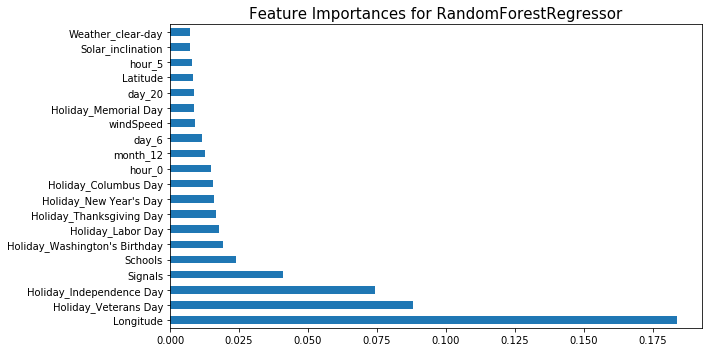

In [323]:
fig, ax = plt.subplots(figsize=(10,5))
feat_importances.nlargest(20).plot(kind='barh', ax=ax)
plt.title('Feature Importances for RandomForestRegressor', fontsize=15)
plt.tight_layout()
plt.savefig('RandomForestRegressor.pdf')

In [324]:
yd_train=yd_train.groupby('Date').sum();

Text(0.5, 1.0, 'Actual and Predicted to the test set')

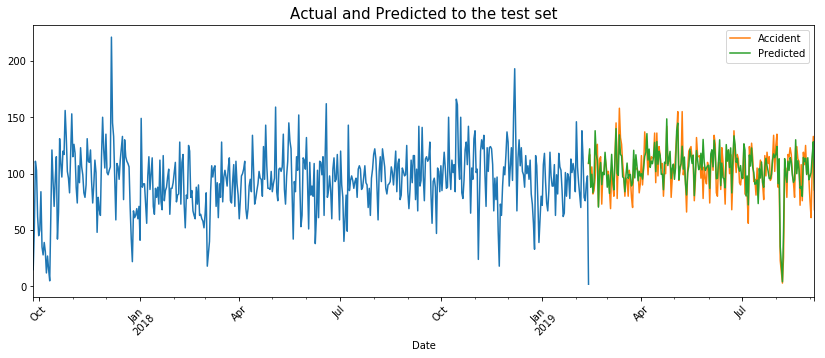

In [325]:
fig, ax=plt.subplots(figsize=(14,5))
yd_train.plot(ax=ax)
yd_ap.plot(ax=ax)
plt.xticks(rotation=45)
ax.set_title('Actual and Predicted to the test set', fontsize=15)

In [326]:
rmse_mae(yd_ap.Accident, yd_ap.Predicted)

R_Square: 0.68 
Root mean squared error (RMSE): 11.990 
The mean absolute percentage error (MAPE): 8.73 %


(array([  0.,  25.,  50.,  75., 100., 125., 150., 175., 200., 225.]),
 <a list of 10 Text xticklabel objects>)

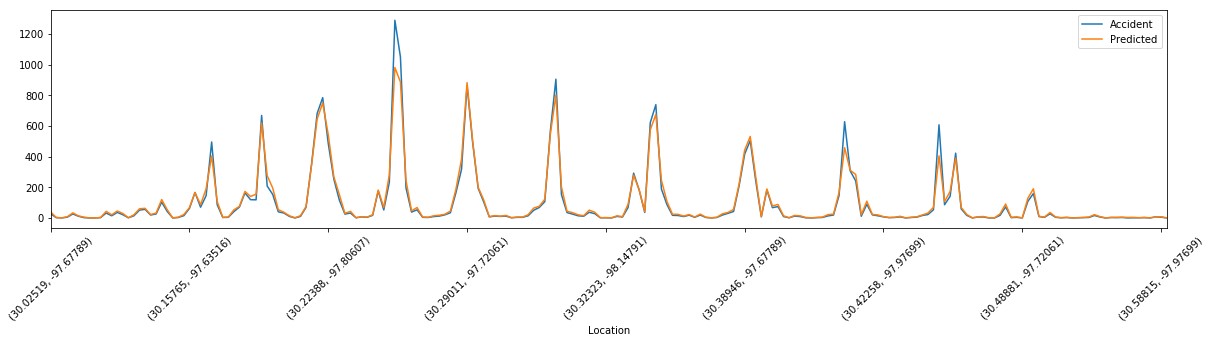

In [327]:
fig, ax = plt.subplots(figsize=(20,4))
yl_ap.plot(ax=ax)
plt.xticks(rotation = 45)

In [328]:
rmse_mae(yl_ap.Accident, yl_ap.Predicted)

R_Square: 0.97 
Root mean squared error (RMSE): 36.511 
The mean absolute percentage error (MAPE): 14.58 %


## A. XGBoosting Model:

### a. XGBRegressor for daily data

Before applying the decision tree for prediction, we want to see the correlation of features to the target variable.

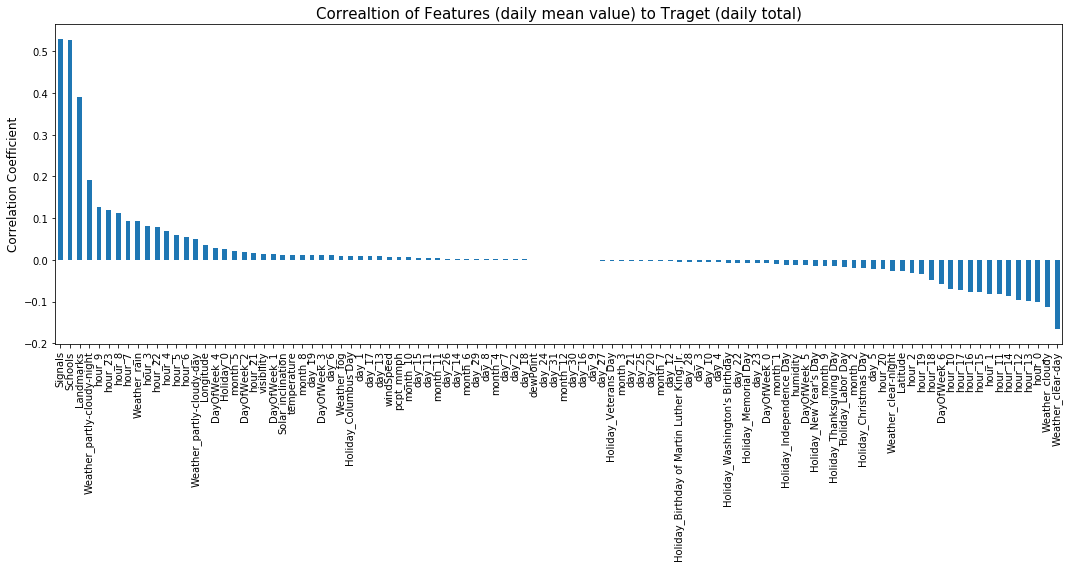

In [336]:
#Calculate the correlation coefficients between the features to the number of accidents
corr_with_Accident = df_d.corr()['Accident'].sort_values(ascending=False)
#plot
fig, ax=plt.subplots(figsize=(15,8))
corr_with_Accident.drop('Accident').plot.bar()
plt.ylabel('Correlation Coefficient', fontsize=12)
plt.title('Correaltion of Features (daily mean value) to Traget (daily total)', fontsize=15)
plt.tight_layout()
plt.savefig('Feat_correlation_to_target.pdf')

In [500]:
#separate the features and target from the whole datafile df_d.
Xddf = df_d.drop(columns=['Accident'])
yd=df_d['Accident']

In [501]:
#Normalize the data so that each of the columns will have mean zero and standard deviation 1.
scaler = StandardScaler()
#Fit the data with scaler and save in pandas fomat
Xd = pd.DataFrame(scaler.fit_transform(Xddf.values), index=Xddf.index, columns=Xddf.columns)

In [502]:
seed = 33
test_size=0.2
#Split data as train and test sets. It will split dataset without changing time order.
Xd_train, Xd_test, yd_train, yd_test, col_list= splitted_data(df_d)
#It will split the data randomly test-size fraction will be separated as test set and remaining as train set.
#Xd_train, Xd_test, yd_train, yd_test = train_test_split(Xd, yd, test_size=test_size, random_state=seed)

In [503]:
#Optimizes the data structures internally for making the memory efficiency and training speed.
data_dmatrix = xgb.DMatrix(data=Xd, label=yd)

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [509]:

xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 10, alpha = 10, n_estimators = 100,subsample=0.75)

In [510]:
#Fit the training data and predict
xg_reg.fit(Xd_train,yd_train)
preds = xg_reg.predict(Xd_test)

[17:24:13] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [390]:
#Predicted data in the pandas frame
y_pred=pd.DataFrame({'Predicted':preds}).reset_index()
#Formatting the test set of the data 
ytest_new=pd.DataFrame(yd_test.reset_index(drop=False)).reset_index()
#Merge the test data and predicted data and sort the file in the ascending order of accidents
test_pred=pd.merge(ytest_new, y_pred, on='index', how='inner').drop('index', axis=1)#.sort_values('Accident')

In [511]:
rmse_mae(test_pred.Accident, test_pred.Predicted)

R_Square: 0.59 
Root mean squared error (RMSE): 1.147 
The mean absolute percentage error (MAPE): 35.20 %


In [512]:
#Cross validation
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 10, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=100,early_stopping_rounds=10, metrics="rmse", as_pandas=True, seed=111)

[17:24:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:24:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:24:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:24:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:24:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [513]:
cv_results.head(), cv_results.tail()

(   train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
 0         2.255655        0.008471        2.256476       0.035144
 1         2.112096        0.011750        2.115957       0.049137
 2         1.995169        0.013486        2.000643       0.040505
 3         1.895476        0.018313        1.902550       0.047158
 4         1.791709        0.017748        1.801991       0.043712,
     train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
 95         0.826029        0.002548        1.059614       0.023809
 96         0.824128        0.002580        1.059419       0.023712
 97         0.821211        0.002652        1.058760       0.023563
 98         0.819525        0.002871        1.058349       0.023648
 99         0.817608        0.002974        1.057745       0.023413)

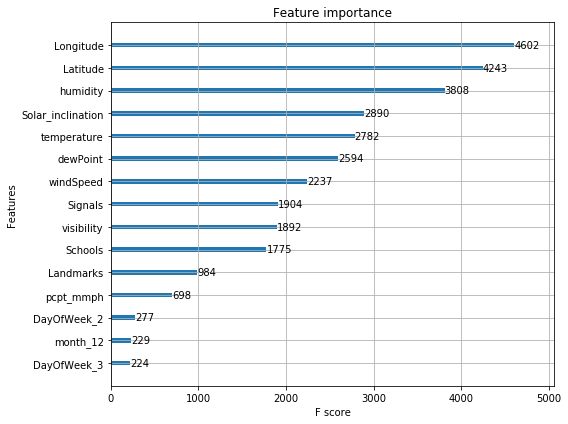

In [514]:
ax=xgb.plot_importance(xg_reg, max_num_features=15)
plt.rcParams['figure.figsize'] = [8,6]
ax.figure.tight_layout()
plt.tight_layout()
plt.savefig('Feat_importances_xgb-daily.pdf')

In [515]:
TP_Loc=test_pred.groupby('Location').sum()
rmse_mae(TP_Loc.Accident, TP_Loc.Predicted)

R_Square: 0.99 
Root mean squared error (RMSE): 17.855 
The mean absolute percentage error (MAPE): 8.05 %


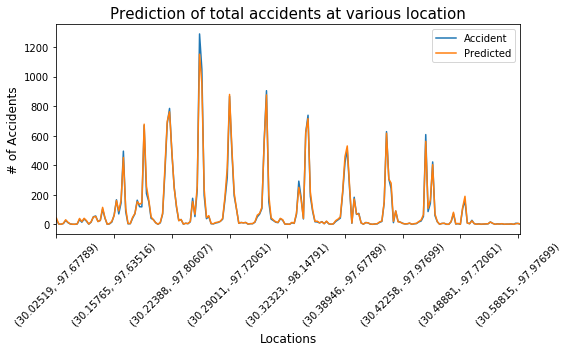

In [516]:
fig, ax=plt.subplots(figsize=(8,5))
TP_Loc.plot(ax=ax)
plt.xticks(rotation=45)
plt.ylabel('# of Accidents', fontsize=12)
plt.xlabel('Locations', fontsize=12)
plt.title('Prediction of total accidents at various location', fontsize=15)
plt.tight_layout()
plt.savefig('xgb_location_accident.pdf')

In [517]:
#Extract the longitude and latitude data from the column "Location" column of the 'TP_Loc'.
TP_l=TP_Loc.reset_index().Location.str.replace(r'[^(]*\(|\)[^)]*', '')
TP_loc=pd.DataFrame(TP_l.map(lambda x: x.split(',')).values.tolist(), columns=['lat', 'long'])
TP_lc=TP_Loc.reset_index().reset_index().merge(TP_loc.reset_index(), on='index').drop(['Location', 'index'], axis=1)
TP_lc['lat']=TP_lc['lat'].astype(float)
TP_lc['long']=TP_lc['long'].astype(float)

In [518]:
from folium import CircleMarker
Austin_COORDINATES = (30.32, -97.7)
sf_map = folium.Map(location=Austin_COORDINATES, zoom_start=10.54)
heatmap1 = folium.plugins.HeatMap(TP_lc[['lat','long']], radius=8)
for i in range(len(TP_lc)):
    actual=float(TP_lc['Accident'][i]*0.2)
    predicted=float(TP_lc['Predicted'][i]*0.2)
    folium.CircleMarker(location=[TP_lc.lat[i], TP_lc.long[i]], radius=abs(actual-predicted), 
                        popup=actual-predicted, fill_opacity=0.01,color='red',fill_color='green', fill=False).add_to(sf_map)
sf_map.add_child(heatmap1)
#sf_map.save('Geo_grid_predict.html')

In [519]:
TP_time=test_pred.groupby('Date').sum()
#Errors
rmse_mae(TP_time.Accident, TP_time.Predicted)

R_Square: 0.75 
Root mean squared error (RMSE): 10.489 
The mean absolute percentage error (MAPE): 8.25 %


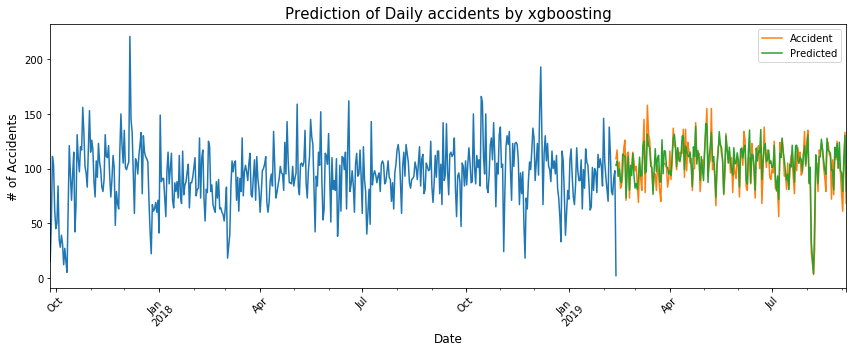

In [520]:
#Plot the daily predicted daily accident along with the actual data. 
yd_train=yd_train.groupby('Date').sum()
fig, ax=plt.subplots(figsize=(12,5))
yd_train.plot(ax=ax)
TP_time.plot(ax=ax)
plt.xticks(rotation=45)
plt.ylabel('# of Accidents', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.title('Prediction of Daily accidents by xgboosting', fontsize=15)
plt.tight_layout()
plt.savefig('Daily_prediction_xgb.pdf')

#### Prediction of daily accidents at specific locations:

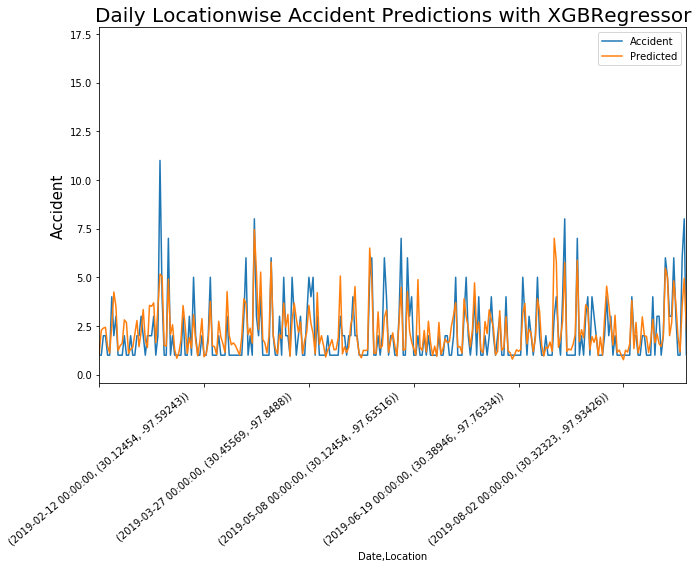

In [547]:
fig, ax = plt.subplots(figsize=(10,8))
ytt.plot(ax=ax)
plt.xlim(5000, 5280)
plt.xticks(rotation=40)
#plt.xlabel('Time-series', fontsize=15)
plt.ylabel('Accident', fontsize=15)
plt.title('Daily Locationwise Accident Predictions with XGBRegressor', fontsize=20)
plt.tight_layout()
plt.savefig('Daily_locationwise')

### b. XGBRegessor for Hourly data 

In [551]:
df1=df0.groupby(['hour', 'Location']).sum()['Accident']

df2 =df0.groupby(['hour', 'Location']).mean()[['Latitude', 'Longitude', 'Signals','Landmarks', 'Schools','windSpeed','visibility','pcpt_mmph','temperature','dewPoint','Solar_inclination', 'humidity']]

df3=df0[['Location','day', 'month', 'DayOfWeek','hour','year', 'Weather', 'Holiday']].groupby(['hour', 'Location']).max()

In [552]:
df3_oh=pd.get_dummies(df3)

In [553]:
df_mid=pd.merge(df2, df3_oh, on=['hour', 'Location'], how='inner')

df=pd.merge(df_mid, df1, on=['hour', 'Location'], how='inner')

In [554]:
corr_with_Accident = df.corr()['Accident'].sort_values(ascending=False)

/usr/local/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


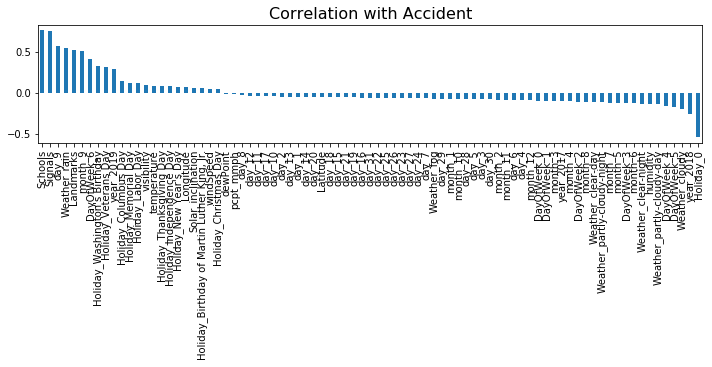

In [555]:
fig, ax=plt.subplots(figsize=(10,5))
ax=corr_with_Accident.drop('Accident').plot.bar()
plt.tight_layout()
plt.xticks(rotation=90)
ax= plt.title('Correlation with Accident', fontsize=16)
plt.savefig('Correlation_with_Accident.pdf')

In [556]:
Xdf = df.drop(columns=['Accident'])
y=df['Accident']

In [557]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(Xdf.values), index=Xdf.index, columns=Xdf.columns)

In [558]:
seed = 7
test_size=0.15
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [559]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


In [560]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100,subsample=0.75)

In [564]:
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)

[17:42:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [566]:
rmse_mae(y_test, preds)

R_Square: 0.91 
Root mean squared error (RMSE): 10.561 
The mean absolute percentage error (MAPE): 28.84 %


In [567]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 10, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=100,early_stopping_rounds=10, metrics="rmse", as_pandas=True, seed=123)

[17:42:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:42:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:42:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:42:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:42:56] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [568]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,36.054009,0.516160,36.172273,2.138397
1,33.322121,0.330892,33.622078,2.164541
2,30.646066,0.241453,31.224102,2.189483
3,28.421500,0.355856,29.252891,2.325766
4,26.284570,0.301099,27.401881,2.089657


In [569]:
print(cv_results.tail())

    train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
95         1.378404        0.048735       10.188443       0.679726
96         1.365322        0.049557       10.187154       0.678073
97         1.352231        0.045509       10.185495       0.680798
98         1.338157        0.044628       10.182693       0.681608
99         1.325070        0.044699       10.179614       0.681299


In [570]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

[17:43:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


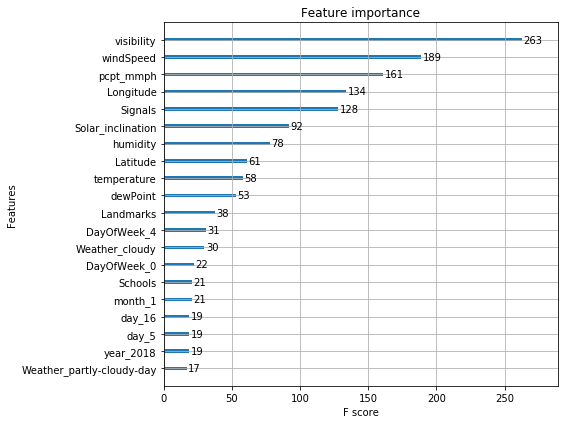

In [575]:
ax=xgb.plot_importance(xg_reg, max_num_features=20)
plt.rcParams['figure.figsize'] = [8, 6]
ax.figure.tight_layout()
plt.savefig('feature_importance.pdf')

In [579]:
rmse_mae(y_test, preds)

R_Square: 0.91 
Root mean squared error (RMSE): 10.561 
The mean absolute percentage error (MAPE): 28.84 %


In [580]:
y_Pred = pd.DataFrame({'pred':preds}).reset_index()
y_Test = y_test.reset_index().reset_index()

In [581]:
ytotal=pd.merge(y_Pred, y_Test, on='index', how='inner').drop('index', axis=1)
ytotal.sort_values('hour', inplace=True)
ytotal.reset_index(inplace=True)

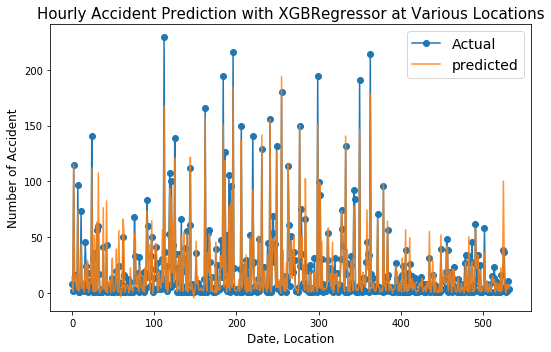

In [589]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(ytotal.Accident, label='Actual',marker='o')
ax.plot(ytotal.pred, label='predicted',alpha=0.85)
plt.legend(fontsize=14, loc=1)
plt.xlabel('Date, Location', fontsize=12)
plt.ylabel('Number of Accident', fontsize=12)
plt.title('Hourly Accident Prediction with XGBRegressor at Various Locations', fontsize=15)
plt.tight_layout()
plt.savefig('predicted_accidents.pdf')

/usr/local/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


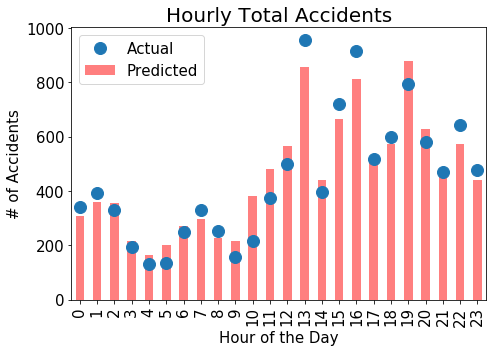

In [586]:
ytotal.hour=ytotal.hour.apply(int)
y_hour=ytotal.drop(['index'], axis=1).groupby('hour').sum()
fig,ax=plt.subplots(figsize=(7,5))
plt.plot(y_hour.Accident, marker='o', markersize=12, linewidth=0, label='Actual')
y_hour.pred.plot('bar', linewidth=3, label='Predicted', color='r', alpha=0.5)
plt.legend(loc=2, fontsize=15)
plt.title('Hourly Total Accidents', fontsize=20)
plt.xlabel('Hour of the Day', fontsize=15)
plt.ylabel('# of Accidents', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig('Hourly_accidents_prediction.pdf')

In [587]:
rmse_mae(y_hour.Accident, y_hour.pred)

R_Square: 0.92 
Root mean squared error (RMSE): 64.235 
The mean absolute percentage error (MAPE): 11.93 %
